# Lesson 8 : Multi object detection

- Video >> https://youtu.be/0frKXR-2PBY
- wiki >> http://forums.fast.ai/t/part-2-lesson-9-in-class/14028/1
- Lesson notes >> https://medium.com/@hiromi_suenaga/deep-learning-2-part-2-lesson-9-5f0cf9e4bb5b

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/08_multiple_object_detection/cours_8.png" width="80%">

We are on the final straight line... to our object detector ! 

But this lesson is certainly one of the most complex one, so stay focused
As usual, we will start gradually and then we will improve step by step to get the expected results

In [0]:
! pip install --upgrade git+https://github.com/keras-team/keras.git \
                        git+https://github.com/valeoai/dl_utils.git \
                        imageio

  Cloning https://github.com/keras-team/keras.git to /tmp/pip-req-build-v3fb3ntx
  Running command git clone -q https://github.com/keras-team/keras.git /tmp/pip-req-build-v3fb3ntx
  Cloning https://github.com/valeoai/dl_utils.git to /tmp/pip-req-build-uw_q4n5p
  Running command git clone -q https://github.com/valeoai/dl_utils.git /tmp/pip-req-build-uw_q4n5p
Requirement already up-to-date: imageio in /usr/local/lib/python3.6/dist-packages (2.5.0)
  Stored in directory: /tmp/pip-ephem-wheel-cache-51_rrf70/wheels/da/a4/7e/6b7bd9af18cc2e23b8dd5ed6de07a7e13bd80a17214eb88932
  Stored in directory: /tmp/pip-ephem-wheel-cache-51_rrf70/wheels/71/ad/e4/ef0ed3b20fc1828e7eb4b7fddc4342ae6a7672d62fa2b89c6a
Successfully built Keras dl-utils
  Found existing installation: Keras 2.2.4
    Uninstalling Keras-2.2.4:
      Successfully uninstalled Keras-2.2.4
  Found existing installation: dl-utils 0.1
    Uninstalling dl-utils-0.1:
      Successfully uninstalled dl-utils-0.1


In [0]:
import keras
from keras.models import Sequential, Model 
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dropout, Flatten,Dense
from keras.optimizers import Adam

import numpy as np
import os
from matplotlib import image,patches,patheffects
import matplotlib.pyplot as plt
from PIL import Image
from pathlib import Path
import json
import collections
import pandas as pd

from dlutils import unpreprocess

# Setup (as previous lesson)

In [0]:
import os
if not os.path.isdir('./VOCdevkit/'):
    ! wget http://pjreddie.com/media/files/VOCtrainval_06-Nov-2007.tar
    ! tar -xf VOCtrainval_06-Nov-2007.tar
    ! wget https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip
    ! unzip -q PASCAL_VOC.zip -d VOCdevkit/VOC2007
    ! mv VOCdevkit/VOC2007/PASCAL_VOC/pascal_train2007.json VOCdevkit/VOC2007/pascal_train2007.json 
    ! rm -Rf VOCdevkit/VOC2007/PASCAL_VOC

In [0]:
PATH = Path('VOCdevkit/VOC2007')
BD = json.load((PATH / 'pascal_train2007.json').open())
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

data_category = dict((o[ID], o['name']) for o in BD[CATEGORIES])
data_filename = dict((o[ID], o[FILE_NAME]) for o in BD[IMAGES])
data_ids = [o[ID] for o in BD[IMAGES]]

IMG_PATH = PATH/'JPEGImages'

In [0]:
def get_annotation():
    annotations = collections.defaultdict(lambda:[])
    for o in BD[ANNOTATIONS]:
        if not o['ignore']:
            bb = o[BBOX]
            bb = np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])
            annotations[o[IMG_ID]].append((bb,o[CAT_ID]))
    return annotations

train_annotation = get_annotation()

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.set_xticks(np.arange(0, 224, 224/4))
    ax.set_yticks(np.arange(0, 224, 224/4))
    ax.grid()
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    return ax

def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

def draw_rect(ax, b, color='white'):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor=color, lw=2))
    draw_outline(patch, 4)

def draw_text(ax, xy, txt, sz=14, color='white'):
    text = ax.text(*xy, txt,
        verticalalignment='top', color=color, fontsize=sz, weight='bold')
    draw_outline(text, 1)
    
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])    

# Bbox prediction on 4*4 cells

We have used up to now the VGG model to perform either image classification, object detection, or both.
As we have explained before, VGG has been pretrained on ImageNet to perform the Classification of 1000 classes.

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/08_multiple_object_detection/VGG_step4.png" width="60%">

We have removed the last layers, specific to ImageNet classification, so that our backbone outputs a feature map. Then, we have stacked behind a Linear layer to do our tasks on PascalVOC.

In a simple view, we have the following architecture:

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/08_multiple_object_detection/VGG_step1.png" width="40%">

and we succeeded to detect and classify the biggest object!

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/08_multiple_object_detection/single_object.png" width="40%">
Now, we want to deal with multiple objects like the following:

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/08_multiple_object_detection/multiple_object.png" width="40%">

Intuitively, instead of having a linear layer of $$(4+c)$$, c being the class (20 length) and 4 values encoding the Bbox coordinates, we can define a linear layer with for instance $$16 * (4+c)$$

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/08_multiple_object_detection/VGG_step2.png" width="40%">

This architecture is called <b>YOLO</b>

There is another option! if we consider once again the feature map of our VGG backbone $$(7*7*512)$$, we can instead of putting a linear layer, just stack behind another <kbd>conv2d</kbd> layer of stride 2. In that case, we will have a tensor of size $$4*4*(512)$$. We can consider 512 being our $$4+c$$

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/08_multiple_object_detection/VGG_step3.png" width="60%">

Finally, another <kbd>conv2d</kbd> of stride 2 will give a $$2*2*(4+c)$$ tensor where each activation will be responsible of a part of the image as illustrated below. This architecture is called <b>SSD</b>

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/08_multiple_object_detection/4_cells.png" width="40%">

Further readings [here](https://www.jeremyjordan.me/object-detection-one-stage/)

# Receptive field
When we convolve an input with a kernel, we have a sliding window moving on the input. Each activation comes from the set of input pixels that the kernel is multiplied by.

![alt text](http://deeplearning.net/tutorial/_images/conv_1D_nn.png)

As we go deeper, each activation has wider reception field of the input.

![alt text](http://deeplearning.net/tutorial/_images/sparse_1D_nn.png)

The same concept applies on 2D conv:

![alt text](http://deeplearning.net/tutorial/_images/cnn_explained.png)

That's why if we reach a 2x2 grid at the output activation, it means that each activation map is "looking" on exactly a quadrant of the input image. So it is the same "as if"we divide the input image into 4 quadrants, but we don't actually intentionally do.

# Stride 2 Conv
From previous lessons, the output size for conv is:
[(N-M+2P)/S + 1]

For 'SAME' conv type P=(M-1)/2, so the size becomes:

N/S + 1

If S=2, then we have output size = N/2 + 1. Which means the size is divided by 2.


## 1. The model

We're going to make a simple first model that simply predicts what object is located in each cell of a 4x4 grid. Later on, we can try to improve this.

As we said before
- VGG output tensor is $$7*7*512$$
- and the desired output of our detector model should be something like following $$4*4*(4+c)$$

So, we are going to create 2 branches in our model:
- one predicting the box coordinates, a tensor of shape $$4*4*4$$. As we did it before, the activation function will be Linear.

- one predicting the class of the object, a tensor of shape $$4*4*20$$. As we did it before, the activation function will be a Sigmoid.

Note: compare to plenty of SSD implementations, we do not introduce 21st class to deal with the background. Indeed, the portions of our image will not necessarily contain an object. Instead of explicitly declaring a new class 'Background' (because it s weird to ask our model to learn the background), we prefer to rely on a Sigmoid activation function where each class are considered independant and therefore, they can all be at zero if there is no object. 

Note that: this time we don't have multi-output model as in single object detection, but we concate the 2 branches.

In [0]:
from keras.layers import Input,GlobalAveragePooling2D, Flatten,Conv2D,Concatenate
from keras.activations import relu, softmax
from keras.models import Model
from keras.layers import BatchNormalization
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D,Activation

sz = 224

def StdConv(kernel_size,stride_size,n_output):    
    def f(input):
        x = Conv2D(kernel_size=kernel_size, filters=n_output, strides=stride_size, padding='same')(input)
        x = Activation(relu)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.25)(x)   

        return x
    
    return f
    
def SSD_Model():
    net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
    for layer in net.layers:
        layer.trainable=False 
        
    x = net.output
    x = Activation(relu)(x)
    x = Dropout(0.25,name='VGG_backbone')(x)   
    
    # Output tensor shape of VGG is [7*7*512]
        
    x = StdConv(kernel_size=3,stride_size=1,n_output=256)(x) #[7*7*256]
    x = StdConv(kernel_size=3,stride_size=2,n_output=128)(x) #[4*4*128]
    
    # (1) classification branch
    nb_cat=20
    x1 = Conv2D(kernel_size=3, filters=nb_cat, strides=1, padding='same')(x)
    #x1 = Dropout(0.5)(x1) 
    x1 = Activation('sigmoid',name='classif')(x1)
    
    # (2) Box regression Branch
    x2 = Conv2D(kernel_size=3, filters=4, strides=1, padding='same')(x)
    x2 = Activation('linear',name='regression')(x2)
    
    # Then, we concatenate the 2 branch together
    out = Concatenate()([Flatten()(x1), Flatten()(x2)])
        
    model = Model(inputs=net.input, outputs=out)

    return model

In [0]:
net = SSD_Model()

In [0]:
net.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_4[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

## 2. The data

In [0]:
mc = [[data_category[p[1]] for p in train_annotation[o]] for o in data_ids] # all object labels 'name' per image, list of images, each of lists of annotations, but only the classes

mc[:3]

[['car'],
 ['person', 'horse'],
 ['bicycle', 'bicycle', 'person', 'person', 'person']]

In [0]:
id2cat = list(data_category.values())
cat2id = {v:k for k,v in enumerate(id2cat)}
mcs = np.array([np.array([cat2id[p] for p in o]) for o in mc]); # all object labels 'id' per image, same as mc, but with id's not names
mcs[:3]

array([array([6]), array([14, 12]), array([ 1,  1, 14, 14, 14])],
      dtype=object)

In [0]:
# Do the same for bboxes
mbb = [np.concatenate([p[0] for p in train_annotation[o]]) for o in data_ids]
mbb[:3] # Each group of 4 is a bbox

[array([ 96, 155, 269, 350]),
 array([ 61, 184, 198, 278,  77,  89, 335, 402]),
 array([229,   8, 499, 244, 219, 229, 499, 333,   0,   1, 368, 116,   1,
          2, 461, 242,   0, 224, 485, 333])]

In [0]:
mbbs = [' '.join(str(p) for p in o) for o in mbb]
mbbs[:3]

['96 155 269 350',
 '61 184 198 278 77 89 335 402',
 '229 8 499 244 219 229 499 333 0 1 368 116 1 2 461 242 0 224 485 333']

In [0]:


df = pd.DataFrame({'filename': [data_filename[o] for o in data_ids], 'bbox': mbbs, 'class':mcs}, columns=['filename','bbox','class'])

def Split_Train_Valid(df,Split_train_val=0.7):
    # step 1: shuffle the data
    df = df.reindex(np.random.permutation(df.index))
    df=df.set_index(np.arange(len(df)))
    
    # step 2: split in training and testing
    df_train = df[:int(len(df)*Split_train_val)]
    df_valid = df[int(len(df)*Split_train_val):]
    df_train=df_train.set_index(np.arange(len(df_train)))
    df_valid=df_valid.set_index(np.arange(len(df_valid)))
    
    return df_train,df_valid

df_train, df_valid = Split_Train_Valid(df,0.7)

In [0]:
df_train[:5]

,filename,bbox,class
0,008254.jpg,50 0 313 417,[7]
1,006896.jpg,110 186 240 223 136 57 270 88 148 28 261 71 13...,"[14, 14, 14, 14, 14]"
2,007483.jpg,34 1 375 499,[14]
3,009869.jpg,5 2 374 352,[14]
4,007606.jpg,40 118 374 414,[14]


We are going to create a generator for our data.
For each image, we can have more than a box. So, we have to define a maximum size.
And because in our model architecture we gather the 2 branches for the regression and classification into a unique tensor, we will do the same for our generator, that is to say gather the box coordinates with the box class like following:

box1: [class_index x1 y1 x2 y2]
box2: [class_index x1 y1 x2 y2]
...
box20: [class_index x1 y1 x2 y2]

this will lead to a matrix of shape [20*5] 

Why 20? because this will the be the max number of boxes we can predict per image.
Dont confuse this 20 with the number of classes.
We have 4x4=16 outputs, so less than 20. We will later control that by letting each quadrant to predict more than 1 box (anchors).


In [0]:
from dlutils.dataset import Generator_MultiObject

train_gen = Generator_MultiObject(df_train, IMG_PATH,preprocess_input,batch_size=32, dim=(sz,sz), shuffle=True)
valid_gen = Generator_MultiObject(df_valid, IMG_PATH,preprocess_input,batch_size=32, dim=(sz,sz), shuffle=True)

## 3. Understand step by step

### 3.1. Anchors

The network we designed previously has 4*4 activations. It looks like a grid.
Each of these square boxes, different papers call them different things. The three terms you’ll hear are: anchor boxes, prior boxes, or default boxes. We will stick with the term anchor boxes

They are defined has follwing:

In [0]:
k=1
anc_grid = 4
anc_offset = 1/(anc_grid*2)
anc_x = np.repeat(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)
anc_y = np.tile(np.linspace(anc_offset, 1-anc_offset, anc_grid), anc_grid)

anc_ctrs = np.tile(np.stack([anc_x,anc_y], axis=1), (k,1))
anc_sizes = np.array([[1/anc_grid,1/anc_grid] for i in range(anc_grid*anc_grid)])
anchors = np.concatenate([anc_ctrs, anc_sizes], axis=1)

Here are the coordinates of all of our anchor boxes (centers, height, width):


In [0]:
print(anchors)#4x4=16

[[0.125 0.125 0.25  0.25 ]
 [0.125 0.375 0.25  0.25 ]
 [0.125 0.625 0.25  0.25 ]
 [0.125 0.875 0.25  0.25 ]
 [0.375 0.125 0.25  0.25 ]
 [0.375 0.375 0.25  0.25 ]
 [0.375 0.625 0.25  0.25 ]
 [0.375 0.875 0.25  0.25 ]
 [0.625 0.125 0.25  0.25 ]
 [0.625 0.375 0.25  0.25 ]
 [0.625 0.625 0.25  0.25 ]
 [0.625 0.875 0.25  0.25 ]
 [0.875 0.125 0.25  0.25 ]
 [0.875 0.375 0.25  0.25 ]
 [0.875 0.625 0.25  0.25 ]
 [0.875 0.875 0.25  0.25 ]]


Note: in this basic configuration, we have only one anchor per activation, that s why we have k=1. We will see later our to increase that value

In [0]:
def hw2corners(ctr, hw): return np.concatenate((ctr-hw/2, ctr+hw/2), axis=1)

anchor_corner = hw2corners(anchors[:,:2], anchors[:,2:])
anchor_corner

array([[0.  , 0.  , 0.25, 0.25],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.5 , 0.25, 0.75],
       [0.  , 0.75, 0.25, 1.  ],
       [0.25, 0.  , 0.5 , 0.25],
       [0.25, 0.25, 0.5 , 0.5 ],
       [0.25, 0.5 , 0.5 , 0.75],
       [0.25, 0.75, 0.5 , 1.  ],
       [0.5 , 0.  , 0.75, 0.25],
       [0.5 , 0.25, 0.75, 0.5 ],
       [0.5 , 0.5 , 0.75, 0.75],
       [0.5 , 0.75, 0.75, 1.  ],
       [0.75, 0.  , 1.  , 0.25],
       [0.75, 0.25, 1.  , 0.5 ],
       [0.75, 0.5 , 1.  , 0.75],
       [0.75, 0.75, 1.  , 1.  ]])

In [0]:
grid_sizes = 1/anc_grid
grid_sizes

0.25

### 3.2. Loss Function
The loss function needs to look at each of these 16 sets of activations, each of which has four bounding box coordinates and c class probabilities and decide if those activations are close or far away from the object which is the closest to this grid cell in the image. If nothing is there, it s supposed to be background

### Matching Problem
The loss function needs to take each of the objects in the image and match them to one of these convolutional grid cells to say “this grid cell is responsible for this particular object” so then it can go ahead and say “okay, how close are the 4 coordinates and how close are the class probabilities.

Here is our goal:

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/08_multiple_object_detection/goal.jpg" width="80%">


Our dependent variable looks like the one on the left, and our final convolutional layer is going to be 4x4x(c+4) in this case c=20. We then flatten that out into a vector. Our goal is to come up with a function which takes in a dependent variable and also some particular set of activations that ended up coming out of the model and returns a higher number if these activations are not a good reflection of the ground truth bounding boxes; or a lower number if it is a good reflection.

### 3.3. Testing

In [0]:
def show_ground_truth(ax, im, bbox, clas=None, prs=None, thresh=0.3):
    bb = [bb_hw(o) for o in bbox]
    if prs is None:  prs  = [None]*len(bb)
    if clas is None: clas = [None]*len(bb)
    ax = show_img(im, ax=ax)
    for i,(b,c,pr) in enumerate(zip(bb, clas, prs)):
        if((b[2]>1) and (pr is None or pr > thresh)):
            draw_rect(ax, bb[i])
            txt = f'{i}: '
            if c is not None: txt += ('bg' if c==len(id2cat) else id2cat[c.astype(int)])
            if pr is not None: txt += f' {pr:.2f}'
            draw_text(ax, b[:2], txt)            

<kbd>get_y()</kbd> is a simple function that returns only the valid ground truth boxes. Indeed, we have defined a maximum size of boxes and our generator will output all the time the same matrix size. So, to keep only relevant boxes, we just check width or height value that should be non zero. All the rest in 'empty' boxes

In [0]:
def get_y(y):
    idx = np.where(y[:,3]-y[:,1]>0)
    bbox = y[idx[0],1:5]
    clas = y[idx[0],0]
    clas=clas.astype('int')
    return bbox,clas

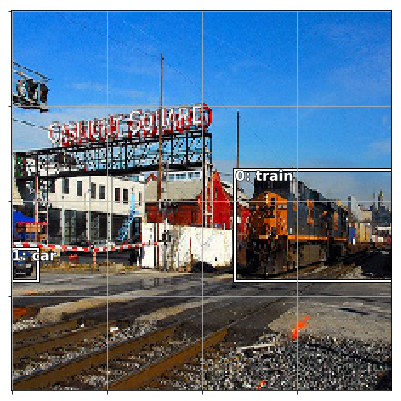

In [0]:
# Let’s now look at the ground truth y
x,y = next(iter(train_gen))

# pick-up an image
i=8
ima = x[i]
Y = y[i].reshape(-1,5)
bbox, clas= get_y(Y)

fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, unpreprocess(ima,'none','none'), bbox*224, clas, None)# *224 since the coordinates are scaled 0..1

Note that bounding box coordinates have been scaled to between 0 and 1 — basically we are treating the image as being 1x1, so they are relative to the size of the image.

Here is our 4x4 grid cells from our final convolutional layer.
We don t have class as we did not perform an inference

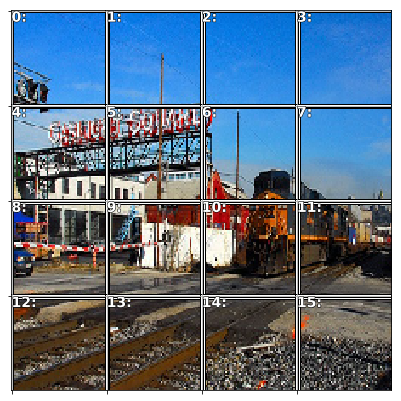

In [0]:
fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, unpreprocess(ima,0,0), anchor_corner*224, None)

Each of these square boxes are called anchor boxes.

What we are going to do for this loss function is we are going to go through a matching problem where we are going to take every one of these 16 boxes and see which one of these three ground truth objects has the highest amount of overlap with a given square. To do this, we have to have some way of measuring amount of overlap and a standard function for this is called Jaccard index (IoU).

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/08_multiple_object_detection/IoU.png" width="40%">

The fancy name of IoU is the Jaccard index!

In [0]:
bbox

array([[0.41811847, 0.588     , 0.70731707, 0.998     ],
       [0.6271777 , 0.        , 0.70731707, 0.064     ]])

In [0]:
bbox.shape

(2, 4)

In [0]:
anchor_corner

array([[0.  , 0.  , 0.25, 0.25],
       [0.  , 0.25, 0.25, 0.5 ],
       [0.  , 0.5 , 0.25, 0.75],
       [0.  , 0.75, 0.25, 1.  ],
       [0.25, 0.  , 0.5 , 0.25],
       [0.25, 0.25, 0.5 , 0.5 ],
       [0.25, 0.5 , 0.5 , 0.75],
       [0.25, 0.75, 0.5 , 1.  ],
       [0.5 , 0.  , 0.75, 0.25],
       [0.5 , 0.25, 0.75, 0.5 ],
       [0.5 , 0.5 , 0.75, 0.75],
       [0.5 , 0.75, 0.75, 1.  ],
       [0.75, 0.  , 1.  , 0.25],
       [0.75, 0.25, 1.  , 0.5 ],
       [0.75, 0.5 , 1.  , 0.75],
       [0.75, 0.75, 1.  , 1.  ]])

In [0]:
anchor_corner.shape

(16, 4)

In [0]:
bbox[:,2:]

array([[0.70731707, 0.998     ],
       [0.70731707, 0.064     ]])

In [0]:
max_xy = np.minimum(bbox[:,None, 2:], anchor_corner[:, 2:])
print(max_xy.shape)
max_xy

(2, 16, 2)


array([[[0.25      , 0.25      ],
        [0.25      , 0.5       ],
        [0.25      , 0.75      ],
        [0.25      , 0.998     ],
        [0.5       , 0.25      ],
        [0.5       , 0.5       ],
        [0.5       , 0.75      ],
        [0.5       , 0.998     ],
        [0.70731707, 0.25      ],
        [0.70731707, 0.5       ],
        [0.70731707, 0.75      ],
        [0.70731707, 0.998     ],
        [0.70731707, 0.25      ],
        [0.70731707, 0.5       ],
        [0.70731707, 0.75      ],
        [0.70731707, 0.998     ]],

       [[0.25      , 0.064     ],
        [0.25      , 0.064     ],
        [0.25      , 0.064     ],
        [0.25      , 0.064     ],
        [0.5       , 0.064     ],
        [0.5       , 0.064     ],
        [0.5       , 0.064     ],
        [0.5       , 0.064     ],
        [0.70731707, 0.064     ],
        [0.70731707, 0.064     ],
        [0.70731707, 0.064     ],
        [0.70731707, 0.064     ],
        [0.70731707, 0.064     ],
        [0.7

In [0]:
bbox[:,None,2:].shape

(2, 1, 2)

In [0]:
anchor_corner[:, 2:].shape

(16, 2)

Now by broadcasting rules, any operation on both matrices will have the max of two indices, starting from the right index--> (4,16,2) (same as you add matrix NxM with vector Nx1, then the result is NxM, applying the add between the vector and each row of the matrix).
This happens by repeating the row M times.

So what we do here is to apply the min or max operation between every box of the 4 and all the 16 anchors. 
In this case, the 2nd dim is None in bbox[:,None,2:], which results in (4,1,2) shape. 
While the anchors are (16,2).
So according to broadcast rules, the (16,2) will be repeated 4 times to be (4,16,2), and the same for the bbox will be repeated 16 times to be (4,16,2). Then the operation (min or max) will take place between every entry to give (4,16,2) points.

In [0]:
max_xy = np.minimum(bbox[:,None,2:], anchor_corner[:, 2:])
min_xy = np.maximum(bbox[:,None,:2], anchor_corner[:, :2])

In [0]:
min_xy.shape

(2, 16, 2)

In [0]:
max_xy.shape

(2, 16, 2)

In [0]:
inter = np.clip((max_xy - min_xy),0,None)
#inter = max_xy - min_xy # If no overlap, then the min_xy > max_xy, so -ve values. In this case the score = 0, as no overlap
inter

array([[[0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.162     ],
        [0.        , 0.248     ],
        [0.08188153, 0.        ],
        [0.08188153, 0.        ],
        [0.08188153, 0.162     ],
        [0.08188153, 0.248     ],
        [0.20731707, 0.        ],
        [0.20731707, 0.        ],
        [0.20731707, 0.162     ],
        [0.20731707, 0.248     ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.162     ],
        [0.        , 0.248     ]],

       [[0.        , 0.064     ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.064     ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.        , 0.        ],
        [0.08013937, 0.064     ],
        [0.08013937, 0.        ],
        [0.08013937, 0.        ],
        [0.08013937, 0.        ],
        [0.        , 0.064     ],
        [0. 

In [0]:
inter_scores = inter[:, :, 0] * inter[:, :, 1]

In [0]:
inter_scores.shape

(2, 16)

In [0]:
def box_sz(b): return ((b[:, 2]-b[:, 0]) * (b[:, 3]-b[:, 1]))#area

def intersect(box_a, box_b):
    
    max_xy = np.minimum(box_a[:,None,2:], box_b[:, 2:])
    min_xy = np.maximum(box_a[:,None,:2], box_b[:, :2])
    
    inter = np.clip((max_xy - min_xy),0,None)
    return inter[:, :, 0] * inter[:, :, 1]

def jaccard(box_a, box_b): # this is the fancy name of IoU!
    inter = intersect(box_a, box_b) 
    union = np.expand_dims(box_sz(box_a),1)+ np.expand_dims(box_sz(box_b),0) - inter  
    
    return inter/union

Here are the amount of overlap between our ground truth objects and the 16 anchor boxes:

In [0]:
overlaps = jaccard(bbox,anchor_corner)
overlaps

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.07904818, 0.1263126 , 0.        , 0.        ,
        0.22771891, 0.39654408, 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.08206272, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [0]:
overlaps.shape

(2, 16)

What we could do now is we could take the max of dimension 1 (row-wise) which will tell us for each ground truth object, what the maximum amount that overlaps with some grid cell as well as the index:

Max overlapp:  [0.39654408 0.08206272]
ID of anchors:  [11  8]


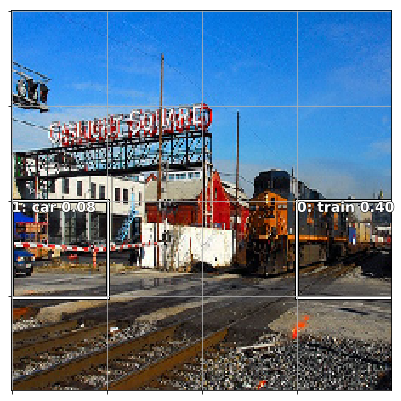

In [0]:
MaxOverlap = np.amax(overlaps,axis=1)
ID_Overlap_Anchor = np.argmax(overlaps,axis=1)

print('Max overlapp: ',MaxOverlap)
print('ID of anchors: ',ID_Overlap_Anchor)

fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, unpreprocess(ima,0,0), anchor_corner[ID_Overlap_Anchor,:]*224, clas, MaxOverlap,0)

We will also going to look at max over a dimension 0 (column-wise) which will tell us what is the maximum amount of overlap for each grid cell across all of the ground truth objects:

In [0]:
MaxOverlap = np.amax(overlaps,axis=0)
ID_Overlap_GT = np.argmax(overlaps,axis=0)

print('Max overlapp: ',MaxOverlap)
print('ID of GT: ',ID_Overlap_GT)

Max overlapp:  [0.         0.         0.         0.         0.         0.
 0.07904818 0.1263126  0.08206272 0.         0.22771891 0.39654408
 0.         0.         0.         0.        ]
ID of GT:  [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


What is particularly interesting here is that it tells us for every grid cell what is the index of the ground truth object which overlaps with it the most. Zero is a bit overloaded here — zero could either mean the amount of overlap was zero or its largest overlap is with object index zero. It is going to turn out not to matter but just FYI.

There is a function called <kbd>map_to_ground_truth</kbd> which we will not worry about for now. It is super simple code but it is slightly awkward to think about. Basically what it does is it combines these two sets of overlaps in a way described in the SSD paper to assign every anchor box to a ground truth object. The way it assign that is each of the three (row-wise max) gets assigned as is. For the rest of the anchor boxes, they get assigned to anything which they have an overlap of at least 0.5 with (column-wise). If neither applies, it is considered to be a cell which contains background.

In [0]:
def map_to_ground_truth(overlaps, print_it=False):
    
    # for each GT, ID of the cell for which overlapp is maximum
    prior_overlap = np.amax(overlaps,1)
    prior_idx = np.argmax(overlaps,1) 
    
    # for each cell, ID of the GT with the best overlapp 
    gt_overlap = np.amax(overlaps,0)
    gt_idx = np.argmax(overlaps,0)
        
    # to ensure each GT matches with an anchor, whatever is the overlapp, meaning even low, 
    # we overwrite the overlapp with a constant value
    gt_overlap[prior_idx] = 1.99 
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    return gt_overlap,gt_idx

In [0]:
gt_overlap,gt_idx = map_to_ground_truth(overlaps)

print(gt_overlap)
print(gt_idx)

[0.         0.         0.         0.         0.         0.
 0.07904818 0.1263126  1.99       0.         0.22771891 1.99
 0.         0.         0.         0.        ]
[0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]


Now you can see a list of all the assignments. Anywhere that has gt_overlap < 0.5 gets assigned background. The three row-wise max anchor box has high number to force the assignments. Now we can combine these values to classes:

In [0]:
gt_clas = clas[gt_idx]; 

print(gt_clas)

[18 18 18 18 18 18 18 18  6 18 18 18 18 18 18 18]


Then add a threshold and finally comes up with the three classes that are being predicted:

In [0]:
thresh = 0.5
pos = gt_overlap > thresh
print(pos)
pos_idx = np.nonzero(pos)
neg_idx = np.nonzero(1-pos)
pos_idx

[False False False False False False False False  True False False  True
 False False False False]


(array([ 8, 11]),)

And here are what each of these anchor boxes is meant to be predicting:

In [0]:
gt_clas[neg_idx] = len(id2cat)
[id2cat[o] if o<len(id2cat) else 'bg' for o in gt_clas]

['bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'bg',
 'car',
 'bg',
 'bg',
 'train',
 'bg',
 'bg',
 'bg',
 'bg']

So that was the matching stage

For L1 loss, we can:
- take the activations which matched (pos_idx)
- subtract from those the ground truth bounding boxes
- take the absolute value of the difference
- take the mean of that.
- For classifications, we can just do a cross entropy

We will end up with 16 predicted bounding boxes, most of them will be background. If you are wondering what it predicts in terms of bounding box of background, the answer is it totally ignores it.

### Tweak: How do we interpret the activations (as modification of the anchor: translation of center and modification of H,W upto 50%)
We grab the activations, we stick them through tanh (remember tanh is the same shape as sigmoid except it is scaled to be between -1 and 1) which forces it to be within that range. We then grab the actual position of the anchor boxes, and we will move them around according to the value of the activations divided by two (actn_bbs[:,:2]/2). In other words, each predicted bounding box can be moved by up to 50% of a grid size from where its default position is. Same for its height and width — it can be up to twice as big or half as big as its default size.

The bboxes are relative to 0,0. This function makes it relative to the center it's corresponding anchor center. We use tanh as the bbox will be centered arount the center of the anchor, so -ve values are allowed. Thats why we divide by 2 also.

Also note, anchors and activations are formatted: [center,x, center_y, h, w].
What we want to do is to translate the center from relative to 0,0 to the center of the anchor. And same for h,w.



In [0]:
def actn_to_bb(actn, anchors):# The bboxes are relative to 0,0. This function makes it relative to the center it's corresponding anchor center. We use tanh as the bbox will be centered arount the center of the anchor, so -ve values are allowed. That's why we divide by 2 also.
    actn_bbs = np.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * grid_sizes) + anchors[:,:2]  
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)

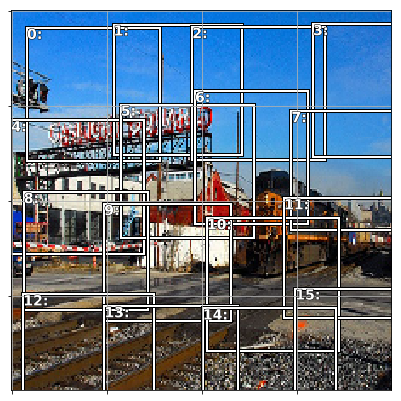

In [0]:
# we generate a random activation: 16*4
b_bbox = np.random.randint(0,224,(16,4));
b_bbox[:,2:] = b_bbox[:,2:] + b_bbox[:,:2]
b_bbox[:,2:] = np.clip(b_bbox[:,2:],0,224)
b_bbox = b_bbox / 224

a_ic = actn_to_bb(b_bbox, anchors)

fig, ax = plt.subplots(figsize=(7,7))
show_ground_truth(ax, unpreprocess(ima,0,0), a_ic*224, None, None)# Note the scaling, as the outputs are 0..1

In [0]:
b_bbox.shape

(16, 4)

### 3.4. Loss from sratch

So far we have:
- Our 16 activations outputted by our model which correpond to our anchor boxes
- A fix size of GT, 20 at max
- A way to convert activations to bounding box
- A way to map anchor boxes to ground truth
- A way to match each of the activation with a GT using the calculate Jaccard index
- A way to deal with background

So, we are missing our Loss function

Our Loss function is composed of 2 terms:
- First term to deal with the prediction of the boxes coordinates. We will use L1 Loss
- Second term to deal with the classification. There is a trick here to deal with background class, __Treat it as multi-class problem__. Indeed, similarly to what we did when we performed multi label classification, we have considered each class independant to be able to predict more than one. what if we just asked for each class; “is it a motorbike?” “is it a bus?”, “ is it a person?” etc and if all the answer is no, consider that background. That is the way we do it here. It is not that we can have multiple true labels, but we can have zero.

In the following cells, we are going to design step by step our Loss, first in numpy and then using the backend


In [0]:
# First, load our data
x_batch,y_batch = next(iter(train_gen))

# then, make a prediction
y_pred = net.predict_on_batch(x_batch)

# for the next step, let consider only one sample from the batch
id_sample = 2
X = x_batch[id_sample]
y_GT = y_batch[id_sample]
y_pred = y_pred[id_sample]

#### Step 1: we split the tensor into box and class for both GT and prediction

In [0]:
# GT: the vector size is 20*(1+4) = 100, where we have [num class, 4 box coordinates] *20
print('GT shape',y_GT.shape)

y_GT = y_GT.reshape(-1,5)
gt_box,gt_clas = get_y(y_GT)

print('GT Box shape',gt_box.shape)
print('GT Class shape',gt_clas.shape)

# The prediction: the tensor size is [16*20 +  16*4], where 16 is the number of activation, and then we have 
# a one hot vector class and 4 box coordinates
print('Prediction tensor shape',y_pred.shape)
pred_clas = np.reshape(y_pred[:16*20],(16,20))
pred_box = np.reshape(y_pred[16*20:],(16,4))
print('Prediction clas shape',pred_clas.shape)
print('Prediction box shape',pred_box.shape)

GT shape (100,)
GT Box shape (4, 4)
GT Class shape (4,)
Prediction tensor shape (384,)
Prediction clas shape (16, 20)
Prediction box shape (16, 4)


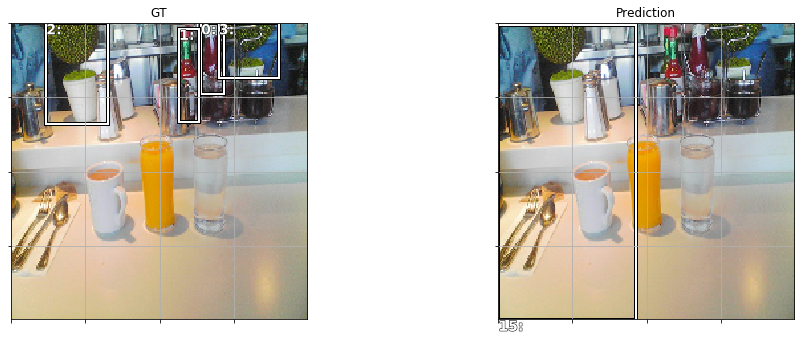

In [0]:
# just have a look to the data
plt.figure(1,figsize=(16, 12))
ax1=plt.subplot(2, 2, 1)
ax1.set_title('GT')
show_ground_truth(ax1, unpreprocess(X,0,0), gt_box*224)
ax2=plt.subplot(2, 2, 2)
ax2.set_title('Prediction')
show_ground_truth(ax2, unpreprocess(X,0,0), np.clip(pred_box,0,1)*224)

#### Step 2: we convert activation into box

In [0]:
a_ic = actn_to_bb(pred_box, anchors)

#### Step 3: we estimate the overlapp between the gt and the anchor

In [0]:
overlaps = jaccard(gt_box, anchor_corner)

#### Step 4: we map with the GT

In [0]:
# it returns for each cell the best overlapp with the GT and the GT id
gt_overlap,gt_idx = map_to_ground_truth(overlaps,0) 
sel_gt_clas = gt_clas[gt_idx]

In [0]:
sel_gt_clas

array([15, 15,  4, 15, 15, 15,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4])

#### Step 5: We threshold the overlapp to keep only "active" anchors

In [0]:
pos = gt_overlap > 0.4
pos_idx = np.nonzero(pos)[0]# idx of anchors
neg_idx = np.nonzero(1-pos)[0]
# we keep neg_idx for a next step, where it will be used to tell to our Loss that there is 
# nothing in that cell to consider, meaning it a a background cell

sel_gt_bbox = gt_box[gt_idx]

In [0]:
gt_idx#assignation of each of the 16 anchors to the gt_box idx. In this case it's just 1 so all are index 0.

array([2, 2, 1, 3, 2, 2, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [0]:
gt_box.shape

(4, 4)

In [0]:
gt_box[gt_idx].shape

(16, 4)

In [0]:
gt_overlap.shape

(16,)

In [0]:
pos

array([ True, False,  True,  True, False, False, False, False, False,
       False, False, False, False, False, False, False])

In [0]:
pos_idx#anchor #5 is the 1 that passed the threshold.

array([0, 2, 3])

In [0]:
sel_gt_bbox.shape

(16, 4)

In [0]:
sel_gt_bbox# It means all anchors are assigned the same gt_bbox. Below we will select only those who passed IoU>thresh --> sel_gt_bbox[pos_idx]

array([[0.        , 0.118     , 0.336     , 0.322     ],
       [0.        , 0.118     , 0.336     , 0.322     ],
       [0.01866667, 0.566     , 0.328     , 0.63      ],
       [0.        , 0.7       , 0.17866667, 0.898     ],
       [0.        , 0.118     , 0.336     , 0.322     ],
       [0.        , 0.118     , 0.336     , 0.322     ],
       [0.01866667, 0.566     , 0.328     , 0.63      ],
       [0.        , 0.64      , 0.23466667, 0.712     ],
       [0.        , 0.64      , 0.23466667, 0.712     ],
       [0.        , 0.64      , 0.23466667, 0.712     ],
       [0.        , 0.64      , 0.23466667, 0.712     ],
       [0.        , 0.64      , 0.23466667, 0.712     ],
       [0.        , 0.64      , 0.23466667, 0.712     ],
       [0.        , 0.64      , 0.23466667, 0.712     ],
       [0.        , 0.64      , 0.23466667, 0.712     ],
       [0.        , 0.64      , 0.23466667, 0.712     ]])

#### Step 6: localization Loss
Here we get the loss between the activation bbox of each anchor (not the anchor itself for sure) and the GT 

In [0]:
loc_loss = np.mean(np.sum(np.abs(a_ic[pos_idx] - sel_gt_bbox[pos_idx]),axis=1))
print('Localization loss is: ',loc_loss)
print('It means an average error in pixel of: ',loc_loss*224)

Localization loss is:  0.483428115857972
It means an average error in pixel of:  108.28789795218573


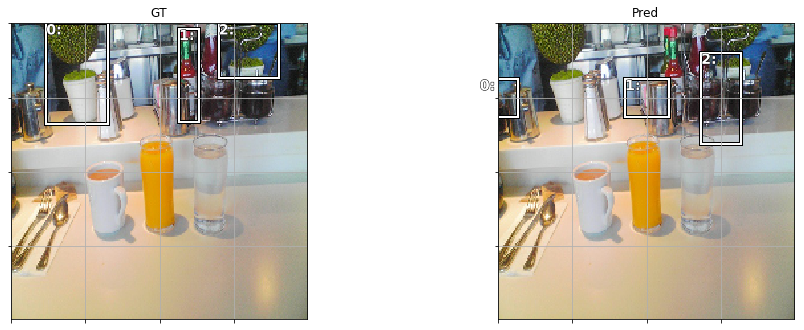

In [0]:
# just have a look to the data
plt.figure(1,figsize=(16, 12))
ax1=plt.subplot(2, 2, 1)
ax1.set_title('GT')
show_ground_truth(ax1, unpreprocess(X,0,0), sel_gt_bbox[pos_idx]*224)
ax1=plt.subplot(2, 2, 2)
ax1.set_title('Pred')
show_ground_truth(ax1, unpreprocess(X,0,0), a_ic[pos_idx]*224)

The overlaps were really close:

See how 5,6 and 9,10 are close!

Also, we are only allowing 50% modif of the anchor cell

That's why you can see the pred vs. GT are very far, since pred not allowed to grow as a big box. This is because the 4x4 grid makes it hard to see the whole big car in one anchor. We need really to allow for bigger anchors than a grid! (Use many anchors and use K-means to identify anchors)


In [0]:
overlaps

array([[0.        , 0.        , 0.270336  , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.21936427, 0.        , 0.        ,
        0.        , 0.0645751 , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.33658357, 0.15923003, 0.        , 0.        , 0.09484343,
        0.04959472, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.10043923, 0.37017266, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ]])

In [0]:
# The gt_box is:
gt_box*224 # not that it's normalized

array([[  0.        , 143.36      ,  52.56533333, 159.488     ],
       [  4.18133333, 126.784     ,  73.472     , 141.12      ],
       [  0.        ,  26.432     ,  75.264     ,  72.128     ],
       [  0.        , 156.8       ,  40.02133333, 201.152     ]])

#### Step 7: Classification Loss
We will use the Binary Cross Entropy as we did in the previous lesson to treat it as multi-class problem to be able to handle the background.
We use here neg_idx to suppress the anchors that didnot pass the thresh

In [0]:
# we will use the Binary Cross Entropy as we did in the previous lesson
# pos_idx is the id of anchor box, all the rest should ba at zero because it does not contain any box
from keras import backend as K

label = keras.utils.to_categorical(sel_gt_clas, 20)# 20 here is the number of classes
label[neg_idx,:]=0

clas_loss = K.eval(K.mean(K.binary_crossentropy(K.cast(label,"float64"), K.cast(pred_clas,"float64"))))

print("Binary Cross Entropy loss = ",clas_loss)

Binary Cross Entropy loss =  2.9761825041925056


#### Step 8: the final Loss

In [0]:
# there is a scale difference between classification Loss (around 4) and localization Loss (around 0.4). 
# So, we put a weight of 10 on the localization Loss
Loss = clas_loss + loc_loss*10
print("The Global Loss is = ",Loss)

The Global Loss is =  7.810463662772225


Finally, we are supposed to loop over our batch.

So, our Loss function will be as following

In [0]:
from keras import backend as K

def SSD_Loss_1(y_GT,y_pred):
    
    # Step 1: we split the tensor into box and class for both GT and prediction
    y_GT = y_GT.reshape(-1,5)
    
    gt_box,gt_clas =  get_y(y_GT)

    pred_clas = y_pred[:20*16]
    pred_box = y_pred[20*16:]
    pred_clas = pred_clas.reshape(-1,20)
    pred_box = pred_box.reshape(-1,4)

    # step 2: we convert activation into box
    a_ic = actn_to_bb(pred_box, anchors)
        
    # step 3: we estimate the overlapp between the activation and the anchor
    overlaps = jaccard(gt_box, anchor_corner)
    
    # step 4: we map with the GT
    prior_overlap = np.amax(overlaps,1) # [20] for each GT, value of tye best overlapp
    prior_idx = np.argmax(overlaps,1) # [20] for each GT, ID of best anchors   
    gt_overlap = np.amax(overlaps,0) # [16] for each cell, ID of the GT with the best overlapp 
    gt_idx = np.argmax(overlaps,0) # [16] for each activation, ID of the GT with the best overlapp   
            
    # We ensure that for each gt box, we select an activation
    gt_overlap[prior_idx] = 1.99
    for i,o in enumerate(prior_idx): gt_idx[o] = i
    
    sel_gt_clas = gt_clas[gt_idx]

    # setp 5: We threshold the overlapp to keep only "active" anchors
    pos = gt_overlap > 0.4
    pos_idx = np.nonzero(pos)[0]
    neg_idx = np.nonzero(1-pos)[0]
    sel_gt_bbox = gt_box[gt_idx]
   
    # step 6: localization Loss   
    loc_loss = np.mean(np.sum(np.abs(a_ic[pos_idx] - sel_gt_bbox[pos_idx]),axis=1))
    
    # step 7: Classification Loss
    # we will use the Binary Cross Entropy as we did in the previous lesson
    # pos_idx is the id of anchor box, all the rest shoudl ba at zero because it does not contain any box
    label = keras.utils.to_categorical(sel_gt_clas, 20)
    label[neg_idx,:]=0

    clas_loss = K.eval(K.mean(K.binary_crossentropy(label, pred_clas)))

    
    print('localization Loss:',loc_loss)
    print('classification loss:',clas_loss)
    return clas_loss + 10*loc_loss

def SSD_Loss(y_batch,y_pred):
    loss = 0
    for y_b,y_p in zip(y_batch,y_pred):
        loss += SSD_Loss_1(y_b,y_p)
    
    return loss

In [0]:
#SSD_Loss(np.expand_dims(y_GT,0),np.expand_dims(y_pred,0))

### 3.5. An effective Loss function, the annoying part....

As we have seen during our previous lesson, the Loss function has to be written with the backend.
We have defined our Loss function in a class named <kbd>SSD_LOSS</kbd>

<b>I stronly encourage you to check the implementation. You will learn a lot especially because you have to think about matrix operation, avoid loops, no if conditions... and you have to make it as fast as possible. With all these constraints, you can end up with a real brain teaser.</b>

In [0]:
from dlutils.ssd import SSD_LOSS

loss = SSD_LOSS(k=1,nbClass=20,anchors=anchors,grid_sizes=anc_sizes)

Epoch 1/20
54/54 [==============================] - 24s 452ms/step - loss: 66.0244 - val_loss: 26.7228
Epoch 2/20
54/54 [==============================] - 20s 372ms/step - loss: 25.6777 - val_loss: 24.1860
Epoch 3/20
54/54 [==============================] - 21s 385ms/step - loss: 23.5056 - val_loss: 23.0116
Epoch 4/20
54/54 [==============================] - 20s 376ms/step - loss: 22.2017 - val_loss: 22.5075
Epoch 5/20
54/54 [==============================] - 20s 366ms/step - loss: 21.3905 - val_loss: 22.3810
Epoch 6/20
54/54 [==============================] - 20s 365ms/step - loss: 20.5989 - val_loss: 21.9021
Epoch 7/20
54/54 [==============================] - 21s 381ms/step - loss: 19.9980 - val_loss: 21.8139
Epoch 8/20
54/54 [==============================] - 20s 370ms/step - loss: 19.5461 - val_loss: 22.0313
Epoch 9/20
54/54 [==============================] - 20s 371ms/step - loss: 19.0317 - val_loss: 21.8769
Epoch 10/20
54/54 [==============================] - 20s 364ms/step - los

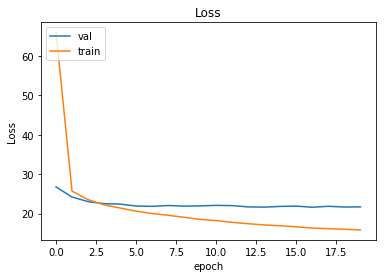

In [0]:
net = SSD_Model()
optimizer=Adam(lr=1e-3)
net.compile(optimizer=optimizer,loss=loss.compute_loss)

history = net.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,                            
                            epochs=20,
                            validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['val', 'train'], loc='upper left')
plt.show()

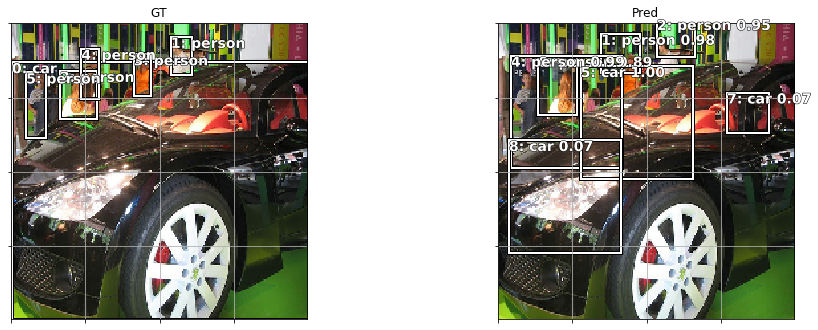

In [0]:
x_batch,y_batch = next(iter(train_gen))
y_pred = net.predict(x_batch)

id_sample = 2
X = x_batch[id_sample]
y_GT = y_batch[id_sample]

y_GT = y_GT.reshape(-1,5)
gt_box,gt_clas =  get_y(y_GT)

y_pred = y_pred[id_sample]#4x4x(20+4)
pred_clas = np.reshape(y_pred[:16*20],(16,20))
pred_box = np.reshape(y_pred[16*20:],(16,4))
pred_box = actn_to_bb(pred_box,anchors)

proba = np.amax(pred_clas,axis=1)
clas = np.argmax(pred_clas,axis=1)

plt.figure(1,figsize=(16, 12))
ax1=plt.subplot(2, 2, 1)
ax1.set_title('GT')
show_ground_truth(ax1, unpreprocess(X,0,0), gt_box*224,gt_clas)
ax1=plt.subplot(2, 2, 2)
ax1.set_title('Pred')
show_ground_truth(ax1, unpreprocess(X,0,0), pred_box*224,clas,proba,0.05)


Actually, we can not expect our model to behave better; it s far to be perfect but we are operating at only one scale! It means the object should be somehow conatined in the receptive field.
So, to do a better job, we have to improve a bit our model:
- <b>add several scales</b>: our last conv layer was [4x4x128], we can stack few other convolution such as 2x2 and then 1x1 to detect bigger objects
- <b>add more anchors</b>: in our previous approach, we had one anchor box per activation, and each size was the exact size of receptive field. We can add several anchors per activation, each of them being slighty different in size, position, aspect ratio...
- <b> We dont add confidence, which could filter some predictions, so we dont do NMS!
For confidence we define it as in YOLO paper: https://arxiv.org/pdf/1506.02640.pdf
  Pr(Object) ∗ IOU(truth, pred )


# More anchors

## 1. how we generate anchors

we define 3 scales 4x4 which was our previous one, then we apply another convolution, we ended up with a new scale of 2x2 and we do it again to finally get another scale of 1x1

This gives us 4x4 + 2x2 + 1x1 = 21 activations

For each activation, instead of being stuck with a squared acnhor of the size of the receptive field, we define:
- A zoom, from 0.7 to 1.3
- An aspect ratio, squared, vertical and horizontal

That is to say 9 possible anchors per activation


In [0]:
anc_grids = [4,2,1]
# anc_grids = [2]
anc_zooms = [0.7, 1., 1.3]
# anc_zooms = [1.]
anc_ratios = [(1.,1.), (1.,0.5), (0.5,1.)]
# anc_ratios = [(1.,1.)]
anchor_scales = [(anz*i,anz*j) for anz in anc_zooms for (i,j) in anc_ratios]
k = len(anchor_scales)
anc_offsets = [1/(o*2) for o in anc_grids]
k

9

In [0]:
anc_x = np.concatenate([np.repeat(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_y = np.concatenate([np.tile(np.linspace(ao, 1-ao, ag), ag)
                        for ao,ag in zip(anc_offsets,anc_grids)])
anc_ctrs = np.repeat(np.stack([anc_x,anc_y], axis=1), k, axis=0)

In [0]:
def hw2corners(ctr, hw): return np.concatenate((ctr-hw/2, ctr+hw/2), axis=1)


anc_sizes  =   np.concatenate([np.array([[o/ag,p/ag] for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
grid_sizes = np.concatenate([np.array([ 1/ag       for i in range(ag*ag) for o,p in anchor_scales])
               for ag in anc_grids])
anchors = np.concatenate([anc_ctrs, anc_sizes], axis=1)
anchor_cnr = hw2corners(anchors[:,:2], anchors[:,2:])

## 2. The model

We have to update our model according to the few scales we want to handle: 4x4, 2x2 and 1x1

In [0]:
from keras.layers import Input,GlobalAveragePooling2D, Flatten,Conv2D,Concatenate
from keras.activations import relu, softmax
from keras.models import Model
from keras.layers import BatchNormalization

sz = 224
nb_cat = 20

def StdConv(kernel_size,stride_size,n_output):    
    def f(input):
        x = Conv2D(kernel_size=kernel_size, filters=n_output, strides=stride_size, padding='same')(input)
        x = Activation(relu)(x)
        x = BatchNormalization()(x)
        x = Dropout(0.2)(x)

        return x
    
    return f
    
def OutConv(k):
    def f(input):
        x1 = Conv2D(kernel_size=3, filters=nb_cat*k, strides=1, padding='same')(input)
        x1 = Dropout(0.15)(x1) 
        x2 = Conv2D(kernel_size=3, filters=4*k, strides=1, padding='same')(input)

        x1 = Activation('sigmoid')(x1)
        x2 = Activation('linear')(x2)
        x1 = Flatten()(x1)
        x2 = Flatten()(x2)
        return x1,x2
    
    return f    

def SSD_Model(k=1):
    net = VGG16(include_top=False, weights='imagenet', input_shape=(sz,sz,3))
    for layer in net.layers:
        layer.trainable=False 
        
    x = net.output
    x = Activation(relu)(x)
    x = Dropout(0.25,name='VGG_backbone')(x)   
    
    # Output tensor shape of VGG is [7*7*512]
        
    x = StdConv(kernel_size=3,stride_size=1,n_output=256)(x) #[7*7*256]
    x = StdConv(kernel_size=3,stride_size=2,n_output=256)(x) #[4*4*256]
    oc1,ol1 = OutConv(k)(x)
    x = StdConv(kernel_size=3,stride_size=2,n_output=256)(x) #[2*2*256]
    oc2,ol2 = OutConv(k)(x)
    x = StdConv(kernel_size=3,stride_size=2,n_output=256)(x) #[1*1*256]
    oc3,ol3 = OutConv(k)(x)
    
    # Then, we concatenate ouputs together
    out = Concatenate()([oc1,oc2,oc3,ol1,ol2,ol3])
        
    model = Model(inputs=net.input, outputs=out)

    return model

## 3. The Loss

There is something important to realize when we design an object detector. From all possible candidates, there are much more 'background object' than real object. Indeed, when we look at an image, there are 3 different granularities of convolutional grid (4x4, 2x2, 1x1). The 1x1 is quite likely to have a reasonable overlap with some object because most photos have some kind of main subject. On the other hand, in the 4x4 grid cells, the most of 16 anchor boxes are not going to have a much of an overlap with anything. So if somebody was to say to you “$20 bet, what do you reckon this little clip is?” and you are not sure, you will say “background” because most of the time, it is the background.

In 2018, a model called RetinatNet from the paper "Focal Loss for Dense Object Detection" introduced a novel Loss function to deal with this inbalanced class.

<img src="https://raw.githubusercontent.com/valeoai/tutorial-images/master/images/08_multiple_object_detection/FocalLoss.png" width="60%">


The key thing is this very first picture. 

The blue line is the binary cross entropy loss. If the answer is not a motorbike, and I said “I think it’s not a motorbike and I am 60% sure” with the blue line, the loss is still about 0.5 which is pretty bad. So if we want to get our loss down, then for all these things which are actually back ground, we have to be saying “I am sure that is background”, “I am sure it’s not a motorbike, or a bus, or a person” — because if I don’t say we are sure it is not any of these things, then we still get loss.

That is why the motorbike example did not work. Because even when it gets to lower right corner and it wants to say “I think it’s a motorbike”, there is no payoff for it to say so. If it is wrong, it gets killed. And the vast majority of the time, it is background. Even if it is not background, it is not enough just to say “it’s not background” — you have to say which of the 20 things it is.

So the trick is to trying to find a different loss function that looks more like the purple line. Focal loss is literally just a scaled cross entropy loss. Now if we say “I’m 0.6 sure it’s not a motorbike” then the loss function will say “good for you! no worries”.

The actual contribution of this paper is to add (1 − pt)^γ to the start of the equation which sounds like nothing but actually people have been trying to figure out this problem for years. When you come across a paper like this which is game-changing, you shouldn’t assume you are going to have to write thousands of lines of code. Very often it is one line of code, or the change of a single constant, or adding log to a single place.

In [0]:
from dlutils.ssd import SSD_FOCAL_LOSS

loss = SSD_FOCAL_LOSS(k=k,nbClass=nb_cat,anchors=anchors,grid_sizes=np.stack([grid_sizes,grid_sizes],axis=1))

In [0]:
net = SSD_Model(k=k)
optimizer=Adam(lr=1e-3)
net.compile(optimizer=optimizer,loss=loss.compute_loss)

history = net.fit_generator(train_gen, steps_per_epoch=train_gen.nb_iteration,                            
                            epochs=10,
                            validation_data=valid_gen, validation_steps=valid_gen.nb_iteration)

Epoch 1/10
54/54 [==============================] - 28s 514ms/step - loss: 109.2594 - val_loss: 40.3666
Epoch 2/10
54/54 [==============================] - 23s 422ms/step - loss: 51.7401 - val_loss: 30.4591
Epoch 3/10
54/54 [==============================] - 22s 411ms/step - loss: 47.0777 - val_loss: 25.4853
Epoch 4/10
54/54 [==============================] - 22s 406ms/step - loss: 44.3076 - val_loss: 23.2438
Epoch 5/10
54/54 [==============================] - 22s 408ms/step - loss: 42.8843 - val_loss: 22.6025
Epoch 6/10
54/54 [==============================] - 23s 424ms/step - loss: 41.3890 - val_loss: 21.6175
Epoch 7/10
54/54 [==============================] - 22s 408ms/step - loss: 40.1640 - val_loss: 20.9389
Epoch 8/10
54/54 [==============================] - 22s 408ms/step - loss: 39.1364 - val_loss: 20.4994
Epoch 9/10
54/54 [==============================] - 22s 413ms/step - loss: 38.3794 - val_loss: 20.4047
Epoch 10/10
54/54 [==============================] - 24s 437ms/step - lo

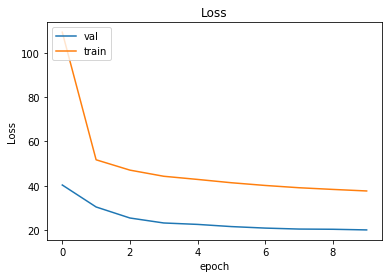

In [0]:
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('Loss')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['val', 'train'], loc='upper left')
plt.show()

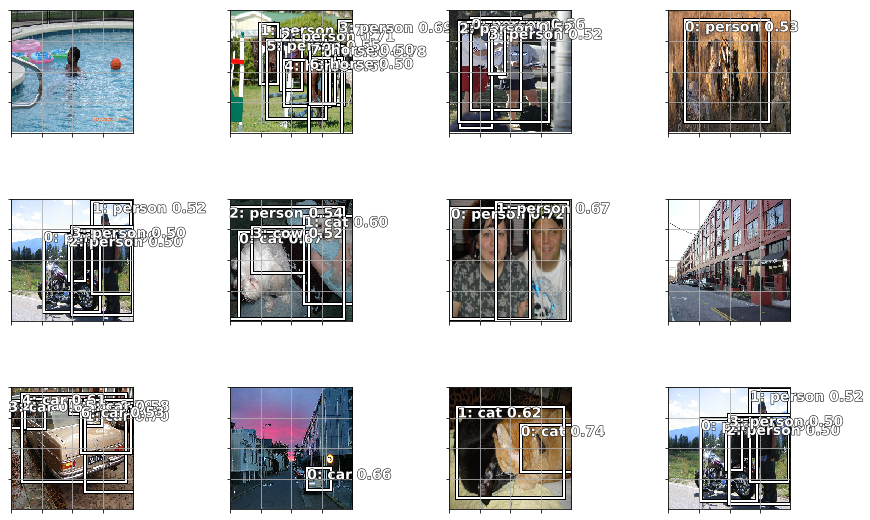

In [0]:
from dlutils.ssd import nms

def actn_to_bb(actn, anchors):
    actn_bbs = np.tanh(actn)
    actn_centers = (actn_bbs[:,:2]/2 * np.stack([grid_sizes,grid_sizes],axis=1)) + anchors[:,:2]
    actn_hw = (actn_bbs[:,2:]/2+1) * anchors[:,2:]
    return hw2corners(actn_centers, actn_hw)


fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    x_batch,y_batch = next(iter(train_gen))
    id_sample = np.random.randint(0,len(x_batch)-1)
    ima = x_batch[id_sample]
    
    y_pred = net.predict(ima[None,:])[0]
    y_GT = y_batch[id_sample]
    
    pred_clas = np.reshape(y_pred[:len(grid_sizes)*20],(len(grid_sizes),20))
    pred_box = np.reshape(y_pred[len(grid_sizes)*20:],(len(grid_sizes),4))
    pred_box = actn_to_bb(pred_box,anchors)

    proba = np.amax(pred_clas,axis=1)
    clas = np.argmax(pred_clas,axis=1)

    id_to_keep = nms(pred_box,proba,0.5)

    show_ground_truth(ax, unpreprocess(ima,0,0), pred_box[id_to_keep,:]*224,clas[id_to_keep],proba[id_to_keep],0.5)

plt.tight_layout()

In [0]:
id_to_keep

[181,
 156,
 57,
 174,
 170,
 165,
 48,
 162,
 157,
 51,
 138,
 39,
 153,
 172,
 147,
 97,
 163,
 52,
 76,
 154,
 161,
 155,
 164,
 61,
 176,
 142,
 58,
 88,
 141,
 171,
 93,
 186,
 152,
 132,
 33,
 149,
 24,
 25,
 139,
 49,
 41,
 47,
 145,
 34,
 135,
 146,
 104,
 54,
 105,
 136,
 140,
 67,
 137,
 8,
 30,
 3,
 37,
 124,
 106,
 0,
 35,
 63,
 7,
 42]

# Conclusion
We have to admit that SSD concept is simple but an efficient implementation is much more tricky.

Furthermore, it s really crucial to understand what you are doing to get a clear idea of what you should expect.
Do not hesisate to output individually each of the Loss to train and check the Loss, compare them together and put a correct weight.

In the case it does not work as expected, you have to come back on a basic task, such as only box prediction, and then put on the top the classification.

Most of the time, it does not work at first at first, so be patient and analyze how your training behave because this is certainly the best indication you will get.

# END